# Ronit Tsysar 316612803 | Guy Klinger 205413149 | Noa Kles 204938351 | Tal Meridor 313261257

## Python script stock price prediction using linear regression for later use in markovich model

### markovich() function explained:
    Gets the desired stocks to predict upon, as well as test size and amount
    of portfolios to run. for each stock, call price_forecast() in order to run
    linear regression and get predicted price. Then, calculate annual return
    and covariance matrix for all of the stocks. As learned in class,
    markovich model strength is in its ability to consider the variance of each
    pair or group of stocks in order to get a  better, safer portfolio. For
    each stock give random weight in each simulation, calculate, sharpe ration,
    return and vollatility (risk). Finally, plot the efficiency frontier of all
    the portfolios calculated and mark the safest one, the one eith the highest
    sharp ratio and the one with the highest risk.


### price_forecast() function explained:
    Gets stock name, relevant dates and test size. After downloading stock's
    data from yfinance, 4 different features are selected. data is then split
    into train and test sets, inserted in a linear regression model for training
    and prediction. the prediction received from the model are returned to
    markovich  function for portfolio analysis.



In [1]:
!pip install --upgrade yfinance

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
from scipy.optimize import minimize

In [4]:
def price_forecast(stock, start_date, end_date, record_percentage_to_predict):
    """

    """
    df = yf.download(stock, start=start_date, end=end_date)

    df['HL_PCT'] = (df['High'] - df['Low']) / df['Low'] * 100.0
    df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HL_PCT', 'PCT_change', 'Volume']]

    forecast_col = 'Close'
    # forecast_col = 'Adj. Close'
    df.fillna(value=-99999, inplace=True)
    forecast_out = int(math.ceil(record_percentage_to_predict * len(df)))
    df['label'] = df[forecast_col].shift(-forecast_out)
    print(df.head())


    X = np.array(df.drop(['label'], axis=1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]
    df.dropna(inplace=True)
    df['Close'].plot()
    y = np.array(df['label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=record_percentage_to_predict)
    # clf =  svm.SVR() # #LinearRegression()
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(confidence)
    forecast_set = clf.predict(X_lately)
    df['Forecast'] = np.nan

    last_date = df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = datetime.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

    # df['Close'].plot()
    # df['Forecast'].plot()
    # plt.legend(loc=4)
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.show()

    col = df['Forecast']
    col = col.dropna()
    return col

## Applying Markovich model

In [7]:
#def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):
def markovich(start_date, end_date, Num_porSimulation, selected, record_percentage_to_predict):

    #yf.pdr_override()
    frame = {}
    for stock in selected:
        # call price_forecast on each stock and get prediction for it's prices
        price = price_forecast(stock, start_date, end_date, record_percentage_to_predict)
        frame[stock] = price
    #frame.to_csv('1.csv')
    table = pd.DataFrame(frame)
    plt.plot(pd.DataFrame(frame))
    pd.DataFrame(frame).to_csv('Out.csv')

    returns_daily = table.pct_change()
    returns_daily.to_csv('Out1.csv')
    returns_annual = ((1 + returns_daily.mean()) ** 254) - 1
    returns_annual.to_csv('Out2.csv')

    # get daily and covariance of returns of the stock
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 250

    # empty lists to store returns, volatility and weights of imiginary portfolios
    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = Num_porSimulation  # Change porfolio numbers here

    # set random seed for reproduction's sake
    np.random.seed(101)

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns * 100)
        port_volatility.append(volatility * 100)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter, symbol in enumerate(selected):
        portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]

    # reorder dataframe columns
    df = df[column_order]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    # min_volatility1 = df['Volatility'].min()+1
    max_sharpe = df['Sharpe Ratio'].max()
    max_return = df['Returns'].max()
    max_vol = df['Volatility'].max()
    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]
    max_returns = df.loc[df['Returns'] == max_return]
    max_vols = df.loc[df['Volatility'] == max_vol]

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-v0_8-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
    plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
    plt.style.use('seaborn-v0_8-dark')

    plt.xlabel('Volatility (Std. Deviation) Percentage %')
    plt.ylabel('Expected Returns Percentage %')
    plt.title('Efficient Frontier')
    plt.subplots_adjust(bottom=0.4)
    # ------------------ Pritning 3 optimal Protfolios -----------------------
    # Setting max_X, max_Y to act as relative border for window size

    red_num = df.index[df["Returns"] == max_return]
    yellow_num = df.index[df['Volatility'] == min_volatility]
    green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
    multseries = pd.Series([1, 1, 1] + [100 for stock in selected],
                           index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])
    with pd.option_context('display.float_format', '%{:,.2f}'.format):
        plt.figtext(0.2, 0.15, "Max returns Porfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
        plt.figtext(0.7, 0.15, "Sharpe  Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(),
                    bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center',
                    wrap=True)
    plt.show()

[*********************100%***********************]  1 of 1 completed

test
Price           Close    HL_PCT PCT_change     Volume       label
Ticker            SPY                             SPY            
Date                                                             
2009-01-02  68.760574  3.995553   2.786374  227566300  107.537857
2009-01-05  68.679214  1.926221   0.237505  240349700  108.408241
2009-01-06  69.137802  1.909794  -0.181544  328260900  109.824677
2009-01-07  67.066696  2.283820  -1.445654  280899200  108.519043
2009-01-08  67.340378  1.583582   0.976040  263834400  108.447777
0.9580911434531677



C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))
d:\studies\s8\algotrade\code\Algotrade\.conda\Lib\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))

C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.dro

Price            Close    HL_PCT PCT_change  Volume        label
Ticker         TA35.TA                      TA35.TA             
Date                                                            
2009-01-01  667.390015  2.128178   1.379292       0  1129.430054
2009-01-04  674.239990  1.713038  -0.580967       0  1135.660034
2009-01-05  679.950012  1.438919   0.793068       0  1146.780029
2009-01-06  702.900024  2.960334   2.909095       0  1141.569946
2009-01-07  694.580017  2.172404  -0.465729       0  1144.849976
0.6074786512944306


[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))

C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change  Volume      label
Ticker            IEI                          IEI           
Date                                                         
2009-01-02  86.699341  1.115960  -0.940388   78500  99.045471
2009-01-05  86.759766  0.435920  -0.225775  487100  98.948059
2009-01-06  86.842888  0.708356   0.410338  363700  98.858788
2009-01-07  86.978775  0.400941   0.243668   67400  99.053635
2009-01-08  87.144867  0.399999   0.130142   34800  99.118538
-1.9818078634470262


[*********************100%***********************]  1 of 1 completed
C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))

C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\226289170.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = np.array(df.drop(['label'], axis=1))


Price           Close    HL_PCT PCT_change   Volume      label
Ticker            LQD                           LQD           
Date                                                          
2009-01-02  54.546349  1.164301  -0.876847  1095800  73.556137
2009-01-05  54.920448  1.638361   1.148279  2938400  73.479744
2009-01-06  55.012573  1.161873   0.217285  2036600  73.511559
2009-01-07  54.551800  1.037407  -0.612401  1675100  73.861778
2009-01-08  54.942093  0.795619   0.735584  1445200  73.861778
0.5570835011131148


C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\3795070049.py:12: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pd.DataFrame(frame))
C:\Users\ronsh\AppData\Local\Temp\ipykernel_36212\3795070049.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = table.pct_change()


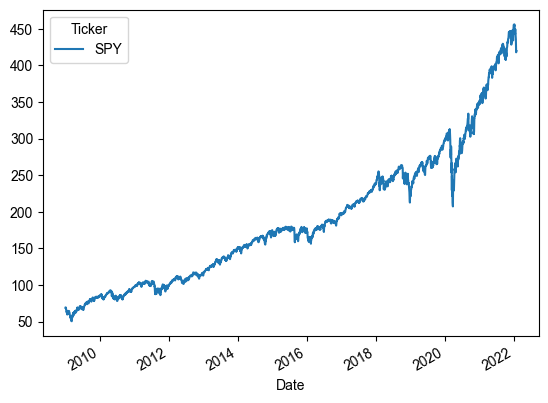

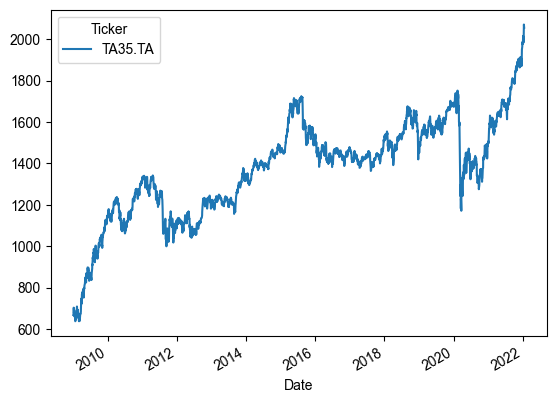

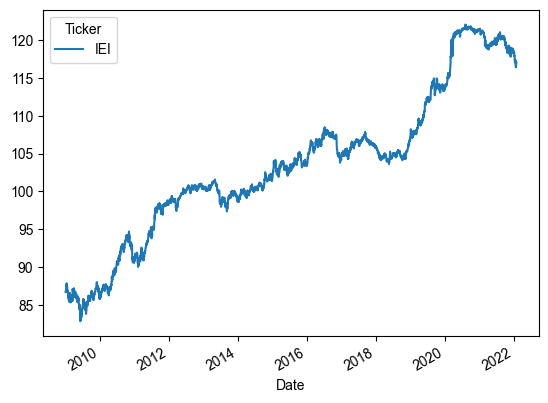

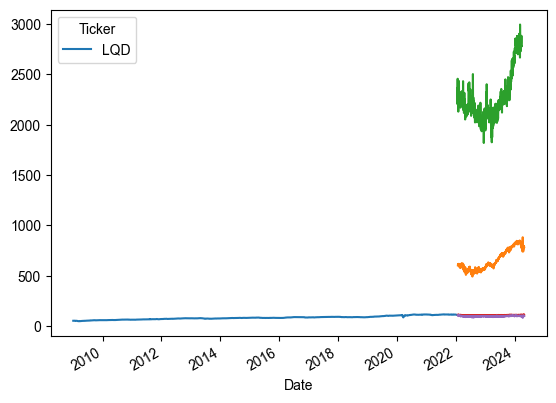

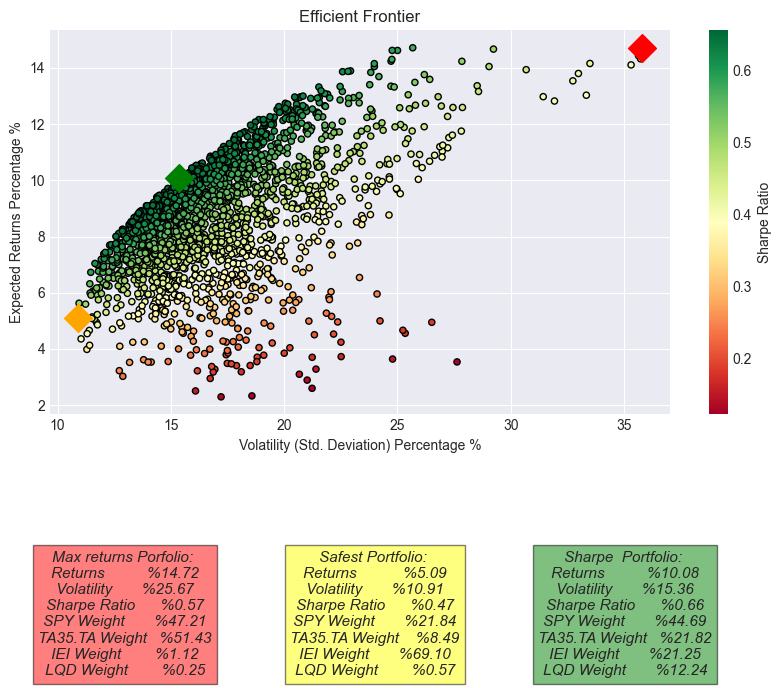

In [8]:

selected = ["SPY", "TA35.TA", "IEI", "LQD"]
record_percentage_to_predict = 0.2
print("test")
markovich("2009-01-01", "2025-05-07", 2000, selected, record_percentage_to_predict)